In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C
import os
import mahotas as mh

In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

2024-05-13 08:55:47.468241: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-13 08:55:50.233218: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 08:55:50.236000: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-13 08:55:50.824012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-13 08:55:50.828100: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/CLEANED/'

In [5]:
data = C.Helper.load_separate_data(DATAPATH, 
                    types=('filt_img', 'filt_lb', 'filt_msk'), subsets=('train', 'test'))

In [6]:
filtered_images_train = data['filt_img_train']
filtered_images_test = data['filt_img_test']
filtered_labels_train = data['filt_lb_train']
filtered_labels_test = data['filt_lb_test']
filtered_masks_train = data['filt_msk_train']
filtered_masks_test = data['filt_msk_test']

In [7]:
normalized_images_train = C.Helper.normalize_data(filtered_images_train)
normalized_images_test = C.Helper.normalize_data(filtered_images_test)

In [8]:
normalized_masks_train = C.Helper.normalize_data(filtered_masks_train)
normalized_masks_test = C.Helper.normalize_data(filtered_masks_test)

In [9]:
last_key = np.concatenate(normalized_images_train[:round(len(normalized_images_train)*0.8)], axis=0)

In [10]:
X_train = np.concatenate(normalized_images_train, axis=0)
X_test = np.concatenate(normalized_images_test, axis=0)
y_train_array = np.concatenate(filtered_labels_train, axis=0)
y_test_array = np.concatenate(filtered_labels_test, axis=0)
m_train = np.concatenate(normalized_masks_train, axis=0)
m_test = np.concatenate(normalized_masks_test, axis=0)

In [11]:
len(X_train), len(X_test)

(449, 265)

In [12]:
new_slices = []
for i in range(len(y_train_array)):
    slices = np.where(y_train_array[i] != 0, True, False)
    new_slices.append(slices)
y_train = np.array(new_slices)

In [13]:
new_slices1 = []
for i in range(len(y_test_array)):
    slices = np.where(y_test_array[i] != 0, True, False)
    new_slices1.append(slices)
y_test = np.array(new_slices1)

In [14]:
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [15]:
train_masks=[]
for i in range(len(m_train)):
    binary = (m_train[i] > 0).astype(np.uint8)
    dilated = mh.dilate(binary.astype(np.bool_))
    for _ in range(9):
        dilated = mh.dilate(dilated)
    train_masks.append(dilated)

In [16]:
train_images=[]
for i in range(len(X_train)):
    train_image = X_train[i] * train_masks[i]
    train_images.append(train_image)
train_images_array = np.array(train_images)

In [17]:
test_masks=[]
for i in range(len(m_test)):
    binary = (m_test[i] > 0).astype(np.uint8)
    dilated = mh.dilate(binary.astype(np.bool_))
    for _ in range(9):
        dilated = mh.dilate(dilated)
    test_masks.append(dilated)

In [18]:
test_images=[]
for i in range(len(X_test)):
    test_image = X_test[i] * test_masks[i]
    test_images.append(test_image)
test_images_array = np.array(test_images)

In [19]:
X_train_set = train_images_array[:last_key.shape[0]]
y_train_set = y_train[:last_key.shape[0]]
X_val = train_images_array[last_key.shape[0]:]
y_val = y_train[last_key.shape[0]:]

In [20]:
X_train_set.shape, y_train_set.shape

((354, 512, 512, 1), (354, 512, 512, 1))

In [21]:
X_val.shape, y_val.shape

((95, 512, 512, 1), (95, 512, 512, 1))

In [22]:
X_train_set.dtype, y_train_set.dtype

(dtype('float32'), dtype('float32'))

In [23]:
model = C.Helper.create_unet(X_train_set[0].shape)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


2024-05-13 08:56:08.303191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-13 08:56:08.305766: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-13 08:56:08.315692: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2024-05-13 08:56:08.318654: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-13 08:56:08.321154: I tensorflow/core

In [24]:
model, history = C.Helper.train_unet(X_train_set, y_train_set, X_val, y_val, model, epochs=200)

2024-05-13 08:56:09.116220: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-13 08:56:09.138768: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245740000 Hz


Epoch 1/200


2024-05-13 08:56:10.504186: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-13 08:56:11.963591: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-05-13 08:56:13.550574: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-05-13 08:56:13.550598: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-05-13 08:56:13.551475: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-13 08:56:13.658092: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-13 08:56:15.069365: I tensorflow/stream_exec

11/11 [==============================] - 42s 2s/step - loss: 0.4123 - iou: 1.4884e-04 - iou_thresholded: 6.0230e-04 - val_loss: 0.0415 - val_iou: 9.8492e-04 - val_iou_thresholded: 0.0010
Epoch 2/200
11/11 [==============================] - 14s 1s/step - loss: 0.0100 - iou: 9.1762e-04 - iou_thresholded: 0.0012 - val_loss: 0.0010 - val_iou: 8.9464e-04 - val_iou_thresholded: 0.0010
Epoch 3/200
11/11 [==============================] - 10s 927ms/step - loss: 0.0017 - iou: 0.0031 - iou_thresholded: 0.0013 - val_loss: 0.0011 - val_iou: 0.0112 - val_iou_thresholded: 0.0010
Epoch 4/200
11/11 [==============================] - 10s 926ms/step - loss: 0.0013 - iou: 0.0067 - iou_thresholded: 0.0022 - val_loss: 0.0010 - val_iou: 0.0128 - val_iou_thresholded: 0.0010
Epoch 5/200
11/11 [==============================] - 10s 927ms/step - loss: 0.0015 - iou: 0.0073 - iou_thresholded: 8.7023e-04 - val_loss: 6.2830e-04 - val_iou: 0.0112 - val_iou_thresholded: 0.0010
Epoch 6/200
11/11 [=====================

11/11 [==============================] - 10s 927ms/step - loss: 3.9947e-04 - iou: 0.3241 - iou_thresholded: 0.4613 - val_loss: 3.5626e-04 - val_iou: 0.2739 - val_iou_thresholded: 0.4548
Epoch 43/200
11/11 [==============================] - 10s 929ms/step - loss: 3.6320e-04 - iou: 0.3549 - iou_thresholded: 0.4805 - val_loss: 3.1411e-04 - val_iou: 0.3154 - val_iou_thresholded: 0.4774
Epoch 44/200
11/11 [==============================] - 10s 926ms/step - loss: 4.1075e-04 - iou: 0.3513 - iou_thresholded: 0.4931 - val_loss: 3.7321e-04 - val_iou: 0.2562 - val_iou_thresholded: 0.4791
Epoch 45/200
11/11 [==============================] - 10s 931ms/step - loss: 4.4750e-04 - iou: 0.3370 - iou_thresholded: 0.4596 - val_loss: 3.3836e-04 - val_iou: 0.2500 - val_iou_thresholded: 0.2505
Epoch 46/200
11/11 [==============================] - 10s 932ms/step - loss: 5.9933e-04 - iou: 0.2056 - iou_thresholded: 0.2946 - val_loss: 2.6209e-04 - val_iou: 0.2958 - val_iou_thresholded: 0.4034
Epoch 47/200
11/11

11/11 [==============================] - 10s 929ms/step - loss: 2.2082e-04 - iou: 0.4980 - iou_thresholded: 0.6093 - val_loss: 2.9432e-04 - val_iou: 0.4180 - val_iou_thresholded: 0.5535
Epoch 84/200
11/11 [==============================] - 10s 928ms/step - loss: 2.1231e-04 - iou: 0.5152 - iou_thresholded: 0.6422 - val_loss: 3.6322e-04 - val_iou: 0.3484 - val_iou_thresholded: 0.4955
Epoch 85/200
11/11 [==============================] - 11s 1s/step - loss: 2.2942e-04 - iou: 0.5050 - iou_thresholded: 0.6321 - val_loss: 3.0283e-04 - val_iou: 0.4039 - val_iou_thresholded: 0.5275
Epoch 86/200
11/11 [==============================] - 10s 1s/step - loss: 2.0713e-04 - iou: 0.5294 - iou_thresholded: 0.6349 - val_loss: 2.4999e-04 - val_iou: 0.4588 - val_iou_thresholded: 0.5682
Epoch 87/200
11/11 [==============================] - 10s 929ms/step - loss: 2.2244e-04 - iou: 0.5231 - iou_thresholded: 0.6396 - val_loss: 3.3865e-04 - val_iou: 0.3968 - val_iou_thresholded: 0.5248
Epoch 88/200
11/11 [====

11/11 [==============================] - 10s 929ms/step - loss: 1.2187e-04 - iou: 0.6781 - iou_thresholded: 0.7639 - val_loss: 4.6029e-04 - val_iou: 0.4466 - val_iou_thresholded: 0.5071
Epoch 125/200
11/11 [==============================] - 10s 932ms/step - loss: 1.1849e-04 - iou: 0.6956 - iou_thresholded: 0.7793 - val_loss: 4.0693e-04 - val_iou: 0.4547 - val_iou_thresholded: 0.5220
Epoch 126/200
11/11 [==============================] - 10s 928ms/step - loss: 1.2361e-04 - iou: 0.6855 - iou_thresholded: 0.7731 - val_loss: 4.3668e-04 - val_iou: 0.4339 - val_iou_thresholded: 0.5042
Epoch 127/200
11/11 [==============================] - 10s 931ms/step - loss: 1.1330e-04 - iou: 0.6750 - iou_thresholded: 0.7688 - val_loss: 4.1683e-04 - val_iou: 0.4459 - val_iou_thresholded: 0.5120
Epoch 128/200
11/11 [==============================] - 10s 928ms/step - loss: 1.2246e-04 - iou: 0.6906 - iou_thresholded: 0.7717 - val_loss: 3.3682e-04 - val_iou: 0.4560 - val_iou_thresholded: 0.5344
Epoch 129/200


11/11 [==============================] - 10s 933ms/step - loss: 5.9234e-05 - iou: 0.7929 - iou_thresholded: 0.8604 - val_loss: 4.7575e-04 - val_iou: 0.4873 - val_iou_thresholded: 0.5205
Epoch 166/200
11/11 [==============================] - 10s 931ms/step - loss: 5.9913e-05 - iou: 0.8191 - iou_thresholded: 0.8808 - val_loss: 5.2123e-04 - val_iou: 0.4893 - val_iou_thresholded: 0.5118
Epoch 167/200
11/11 [==============================] - 10s 930ms/step - loss: 6.2549e-05 - iou: 0.8114 - iou_thresholded: 0.8697 - val_loss: 5.0378e-04 - val_iou: 0.4873 - val_iou_thresholded: 0.5128
Epoch 168/200
11/11 [==============================] - 10s 928ms/step - loss: 5.9632e-05 - iou: 0.8152 - iou_thresholded: 0.8798 - val_loss: 5.4096e-04 - val_iou: 0.4913 - val_iou_thresholded: 0.5128
Epoch 169/200
11/11 [==============================] - 11s 1s/step - loss: 5.5352e-05 - iou: 0.8317 - iou_thresholded: 0.8872 - val_loss: 5.4632e-04 - val_iou: 0.4817 - val_iou_thresholded: 0.5032
Epoch 170/200
11/

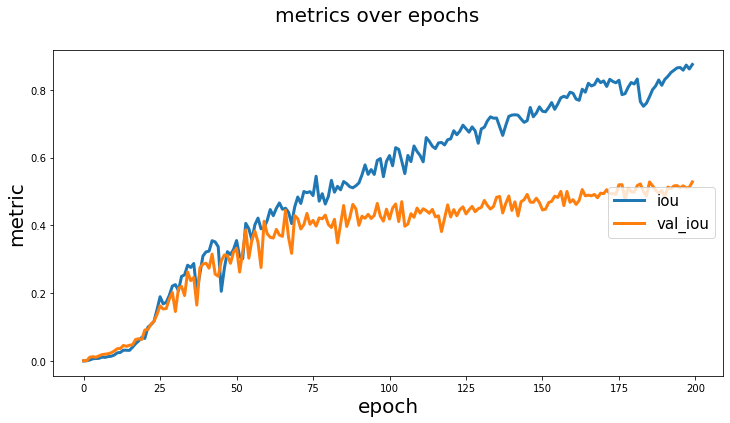

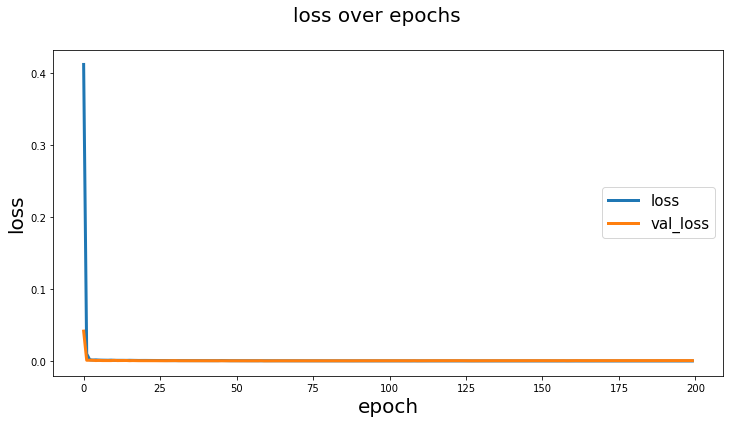

In [25]:
C.Helper.visualize_graph(history)

In [26]:
y_pred = C.Helper.prediction(test_images_array, model)

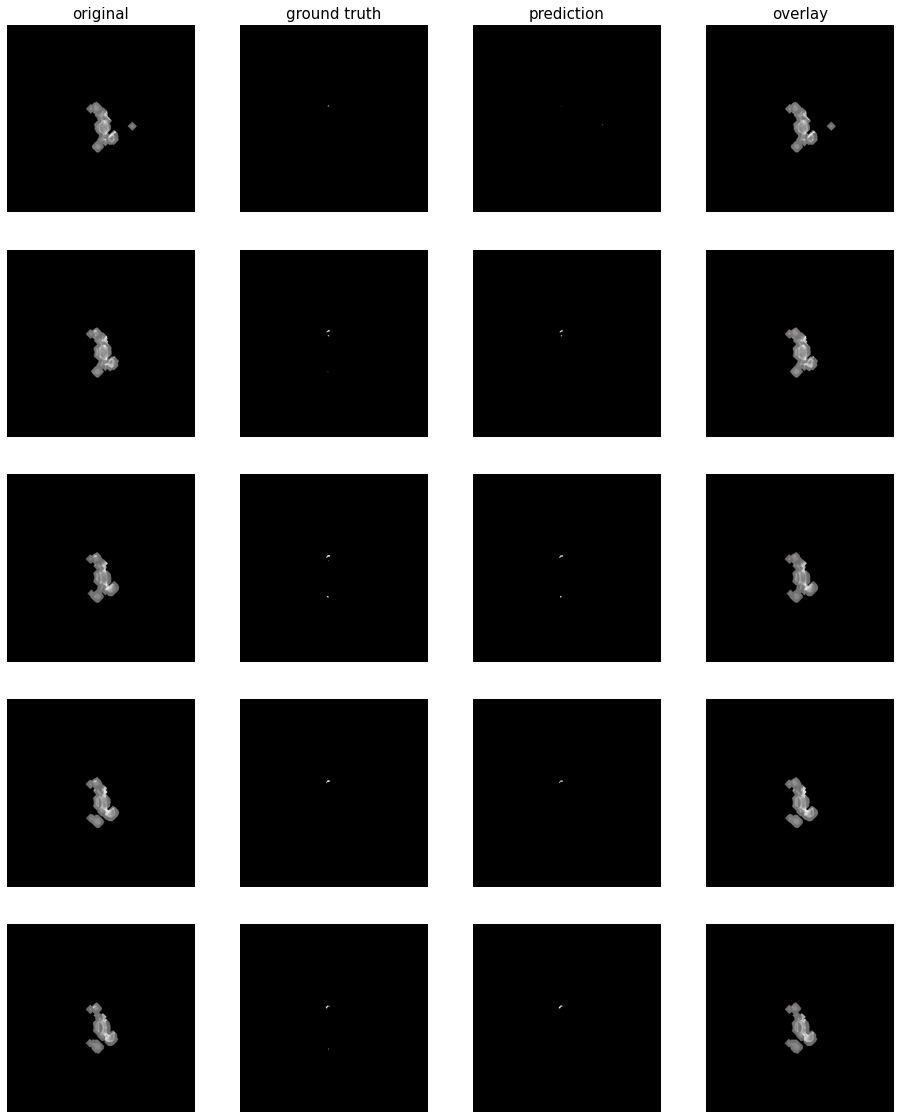

In [27]:
C.Helper.visualize_result(test_images_array, y_test, y_pred)

In [28]:
C.Helper.evaluate(test_images_array, y_test, model)

9/9 [==============================] - 2s 201ms/step - loss: 0.0010 - iou: 0.5307 - iou_thresholded: 0.5442
